In [ ]:
# schema matching without complex dependencies
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load datasets
coursera_df = pd.read_csv('Coursera.csv')
udemy_df = pd.read_csv('udemy_course_data.csv')
recommendation_df = pd.read_csv('personalized_recommendation_dataset.csv')
courses_df = pd.read_csv('Courses.csv')

# 2. Extract column information
def process_column_name(name):
    """Process column name into a descriptive string"""

    name = re.sub(r'([A-Z])', r' \1', name).lower()
    name = name.replace('_', ' ')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

datasets = {
    'coursera': coursera_df,
    'udemy': udemy_df,
    'recommendation': recommendation_df,
    'courses': courses_df
}

# 3. Create column descriptions
column_descriptions = {}
for ds_name, df in datasets.items():
    column_descriptions[ds_name] = {}
    for col in df.columns:
        column_descriptions[ds_name][col] = process_column_name(col)

# 4. Create vectorizer and compute similarity matrices
vectorizer = TfidfVectorizer()
all_descriptions = []
all_col_info = []

for ds_name, cols in column_descriptions.items():
    for col_name, desc in cols.items():
        all_descriptions.append(desc)
        all_col_info.append((ds_name, col_name))

# Fit vectorizer on all descriptions
vectors = vectorizer.fit_transform(all_descriptions)

# 5. Calculate similarity matrices
similarity_pairs = {}
ds_names = list(datasets.keys())

for i in range(len(ds_names)):
    for j in range(i+1, len(ds_names)):
        source_ds = ds_names[i]
        target_ds = ds_names[j]


        source_indices = [idx for idx, (ds, _) in enumerate(all_col_info) if ds == source_ds]
        target_indices = [idx for idx, (ds, _) in enumerate(all_col_info) if ds == target_ds]

        if not source_indices or not target_indices:
            continue

        # Extract vectors
        source_vectors = vectors[source_indices]
        target_vectors = vectors[target_indices]

        # Calculate similarity
        similarity = cosine_similarity(source_vectors, target_vectors)

        # Get column names
        source_cols = [all_col_info[idx][1] for idx in source_indices]
        target_cols = [all_col_info[idx][1] for idx in target_indices]

        similarity_pairs[(source_ds, target_ds)] = {
            'matrix': similarity,
            'source_cols': source_cols,
            'target_cols': target_cols
        }

# 6. Find matches
matches = {}
for ds_pair, sim_data in similarity_pairs.items():
    source_ds, target_ds = ds_pair
    matches[ds_pair] = []

    similarity = sim_data['matrix']
    source_cols = sim_data['source_cols']
    target_cols = sim_data['target_cols']

    # Find best matches above threshold
    for s_idx, s_col in enumerate(source_cols):
        best_match_idx = np.argmax(similarity[s_idx])
        best_match_score = similarity[s_idx, best_match_idx]

        if best_match_score >= 0.5:  # Threshold
            t_col = target_cols[best_match_idx]
            matches[ds_pair].append({
                'source_column': s_col,
                'target_column': t_col,
                'similarity': best_match_score
            })

    print(f"\nMatches between {source_ds} and {target_ds}:")
    for match in matches[ds_pair]:
        print(f"  {match['source_column']} -> {match['target_column']} (similarity: {match['similarity']:.4f})")

# 7. Create integrated schema
all_columns = set()
for ds_name, df in datasets.items():
    all_columns.update(df.columns)

equiv_classes = []
processed_columns = set()

# Process matches to build equivalence classes
for ds_pair, match_list in matches.items():
    for match in match_list:
        source_col = match['source_column']
        target_col = match['target_column']

        # Find existing class
        found_class = None
        for eq_class in equiv_classes:
            if source_col in eq_class or target_col in eq_class:
                found_class = eq_class
                break

        if found_class:
            found_class.add(source_col)
            found_class.add(target_col)
        else:
            equiv_classes.append({source_col, target_col})

        processed_columns.add(source_col)
        processed_columns.add(target_col)

# Add remaining columns
for col in all_columns:
    if col not in processed_columns:
        equiv_classes.append({col})

# Generate integrated schema
integrated_schema = []
for i, eq_class in enumerate(equiv_classes):
    rep_name = min(eq_class, key=len)
    integrated_schema.append({
        'integrated_column': f'integrated_{i}_{rep_name}',
        'original_columns': list(eq_class)
    })

# 8. Combine datasets
integrated_columns = [item['integrated_column'] for item in integrated_schema]
integrated_df = pd.DataFrame(columns=integrated_columns)

for ds_name, df in datasets.items():
    temp_df = pd.DataFrame(index=df.index, columns=integrated_columns)

    for schema_item in integrated_schema:
        integrated_col = schema_item['integrated_column']
        original_cols = schema_item['original_columns']

        for orig_col in original_cols:
            if orig_col in df.columns:
                temp_df[integrated_col] = df[orig_col]
                break

    integrated_df = pd.concat([integrated_df, temp_df], ignore_index=True)

# Save the integrated dataset
integrated_df.to_csv('integrated_educational_courses.csv', index=False)
print("\nIntegrated dataset saved to 'integrated_educational_courses.csv'")


Matches between coursera and udemy:
  Difficulty Level -> level (similarity: 0.6714)
  Course URL -> course_id (similarity: 0.5995)

Matches between coursera and recommendation:
  Course Rating -> Rating (similarity: 0.8004)

Matches between coursera and courses:
  Course URL -> course_id (similarity: 0.5995)

Matches between udemy and recommendation:
  price -> Price (similarity: 1.0000)
  published_timestamp -> Timestamp (similarity: 0.7336)

Matches between udemy and courses:
  course_id -> course_id (similarity: 1.0000)

Matches between recommendation and courses:


<ipython-input-18-412859a717a4>:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  integrated_df = pd.concat([integrated_df, temp_df], ignore_index=True)



Integrated dataset saved to 'integrated_educational_courses.csv'


**Validation of the method**


In [ ]:
c = pd.read_csv('integrated_educational_courses.csv', dtype=str).head()

print(c)

  integrated_0_level                             integrated_1_course_id  \
0           Beginner  https://www.coursera.org/learn/write-a-feature...   
1           Beginner  https://www.coursera.org/learn/canvas-analysis...   
2           Advanced  https://www.coursera.org/learn/silicon-thin-fi...   
3       Intermediate  https://www.coursera.org/learn/operational-fin...   
4           Beginner  https://www.coursera.org/learn/single-table-sq...   

  integrated_2_Rating integrated_3_price integrated_4_Timestamp  \
0                 4.8                NaN                    NaN   
1                 4.8                NaN                    NaN   
2                 4.1                NaN                    NaN   
3                 4.8                NaN                    NaN   
4                 4.6                NaN                    NaN   

  integrated_5_subject integrated_6_index  \
0                  NaN                NaN   
1                  NaN                NaN   
2          

Dataset Shape: (798343, 48)

Column Names:
- integrated_0_level
- integrated_1_course_id
- integrated_2_Rating
- integrated_3_price
- integrated_4_Timestamp
- integrated_5_subject
- integrated_6_index
- integrated_7_Course Description
- integrated_8_course_title
- integrated_9_nforum_posts
- integrated_10_published_date
- integrated_11_nchapters
- integrated_12_viewed
- integrated_13_YoB
- integrated_14_LoE_DI
- integrated_15_Location
- integrated_16_explored
- integrated_17_University
- integrated_18_url
- integrated_19_Platform
- integrated_20_num_lectures
- integrated_21_Item_ID
- integrated_22_Course Name
- integrated_23_published_time
- integrated_24_nevents
- integrated_25_incomplete_flag
- integrated_26_last_event_DI
- integrated_27_certified
- integrated_28_day
- integrated_29_ndays_act
- integrated_30_content_duration
- integrated_31_is_paid
- integrated_32_year
- integrated_33_nplay_video
- integrated_34_profit
- integrated_35_grade
- integrated_36_User_ID
- integrated_37_Cat

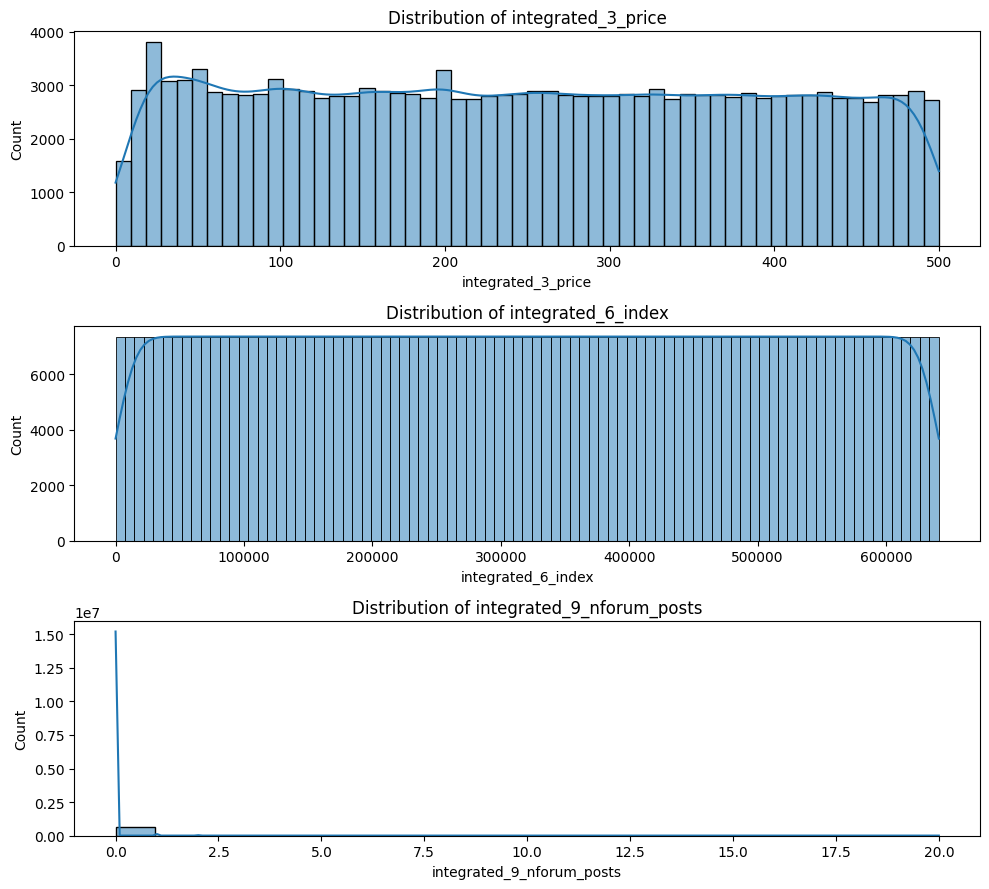

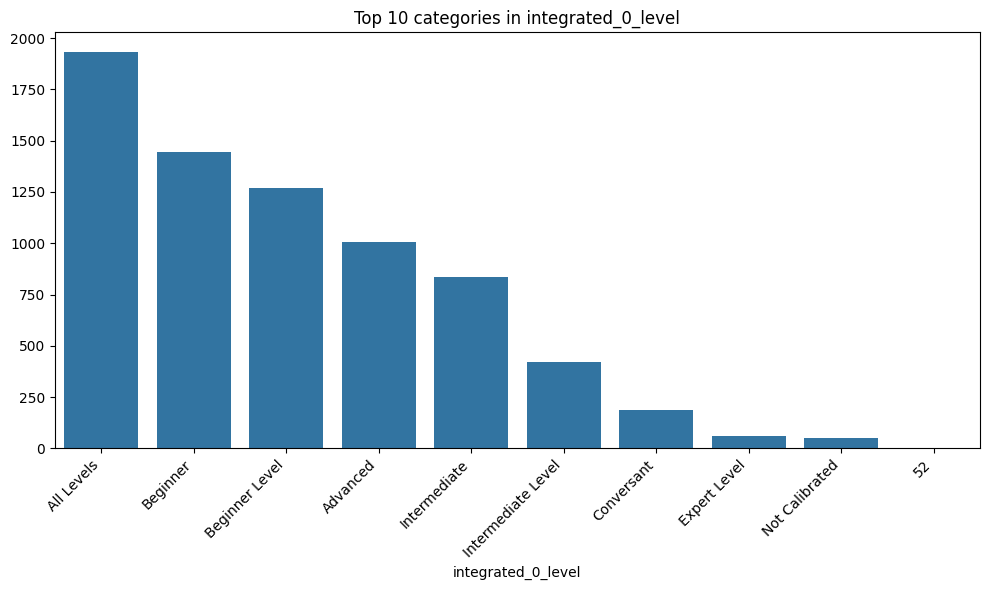

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


integrated_df = pd.read_csv('integrated_educational_courses.csv', low_memory=False)

# 1. Basic Exploration
print("Dataset Shape:", integrated_df.shape)
print("\nColumn Names:")
for col in integrated_df.columns:
    print(f"- {col}")

# 2. Check data types and missing values
print("\nData Types:")
print(integrated_df.dtypes)

print("\nMissing Values Per Column:")
missing_values = integrated_df.isnull().sum()
missing_percent = (missing_values / len(integrated_df)) * 100
missing_info = pd.concat([missing_values, missing_percent], axis=1)
missing_info.columns = ['Missing Count', 'Missing Percent']
print(missing_info)

# 3. View a sample of the data
print("\nData Sample:")
print(integrated_df.head())

# 4. Data Distribution Visualization

numeric_cols = integrated_df.select_dtypes(include=[np.number]).columns.tolist()[:3]

if numeric_cols:
    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, len(numeric_cols)*3))
    for i, col in enumerate(numeric_cols):
        if len(numeric_cols) > 1:
            ax = axes[i]
        else:
            ax = axes
        sns.histplot(integrated_df[col].dropna(), kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# 5. Example analysis - Count by categorical column

categorical_cols = integrated_df.select_dtypes(include=['object']).columns.tolist()[:2]

if categorical_cols:
    for col in categorical_cols:
        if integrated_df[col].nunique() < 15:
            plt.figure(figsize=(10, 6))
            counts = integrated_df[col].value_counts().head(10)
            sns.barplot(x=counts.index, y=counts.values)
            plt.title(f'Top 10 categories in {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

In [ ]:
# Validate the integration process
def validate_integration(integrated_df, original_datasets):
    """Check if the integration preserved important data"""

    print("Validation Report:")

    # 1. Check row counts
    original_rows = sum(len(df) for df in original_datasets.values())
    integrated_rows = len(integrated_df)

    print(f"Original total rows: {original_rows}")
    print(f"Integrated rows: {integrated_rows}")
    print(f"Row preservation: {integrated_rows/original_rows:.2%}")

    # 2. Check for key columns presence
    key_columns = []
    for ds_name, df in original_datasets.items():

        sample_cols = list(df.columns)[:3]
        key_columns.extend([(ds_name, col) for col in sample_cols])

    # Check if these key columns have corresponding integrated columns
    found_cols = 0
    for ds_name, col in key_columns:

        found = any(col.lower() in icol.lower() for icol in integrated_df.columns)
        if found:
            found_cols += 1

    print(f"Key column preservation: {found_cols}/{len(key_columns)} ({found_cols/len(key_columns):.2%})")

    # 3. Check for non-null values
    non_null_percentage = (integrated_df.count().sum() / (integrated_df.shape[0] * integrated_df.shape[1])) * 100
    print(f"Non-null values: {non_null_percentage:.2f}%")

    return {
        "row_preservation": integrated_rows/original_rows,
        "column_preservation": found_cols/len(key_columns),
        "non_null_percentage": non_null_percentage
    }

# Run validation
validation_results = validate_integration(integrated_df, {
    'coursera': pd.read_csv('Coursera.csv'),
    'udemy': pd.read_csv('udemy_course_data.csv'),
    'recommendation': pd.read_csv('personalized_recommendation_dataset.csv'),
    'courses': pd.read_csv('Courses.csv')
})

Validation Report:
Original total rows: 798343
Integrated rows: 798343
Row preservation: 100.00%
Key column preservation: 11/12 (91.67%)
Non-null values: 31.26%
